# TC1 - Problema de Atribuição de Tarefas

**Objetivos:** Minimizar custo total (f_C) e desequilíbrio de carga (f_E)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

## 1. Carregamento de Dados

In [2]:
data_dir = Path('..')

m = pd.read_csv(data_dir / 'data_5x50_m.csv', header=None).values[0, 0]
n = pd.read_csv(data_dir / 'data_5x50_n.csv', header=None).values[0, 0]
a = pd.read_csv(data_dir / 'data_5x50_a.csv', header=None).values
c = pd.read_csv(data_dir / 'data_5x50_c.csv', header=None).values
b = pd.read_csv(data_dir / 'data_5x50_b.csv', header=None).values.flatten()

print(f"Dimensões: m={m}, n={n}")
print(f"Capacidades: {b}")

Dimensões: m=5, n=50
Capacidades: [106.4  126.4  127.04 115.52 112.8 ]


## 2. Verificação de Viabilidade

In [3]:
capacidade_total = b.sum()
demanda_minima = a.min(axis=0).sum()

print(f"Capacidade total: {capacidade_total:.2f}")
print(f"Demanda mínima: {demanda_minima:.2f}")
print(f"Folga: {capacidade_total - demanda_minima:.2f} ({(capacidade_total - demanda_minima)/capacidade_total*100:.1f}%)")
print(f"Status: {'✅ VIÁVEL' if capacidade_total >= demanda_minima else '❌ INVIÁVEL'}")

Capacidade total: 588.16
Demanda mínima: 409.00
Folga: 179.16 (30.5%)
Status: ✅ VIÁVEL


## 3. Funções de Cálculo

In [4]:
def calcular_custo_total(x, c):
    """Custo total: f_C = ΣΣ c_ij × x_ij"""
    return np.sum(c * x)

def calcular_cargas(x, a):
    """Carga por agente: L_i = Σ_j a_ij × x_ij"""
    return np.sum(a * x, axis=1)

def calcular_desequilibrio(x, a):
    """Desequilíbrio: f_E = L_max - L_min"""
    cargas = calcular_cargas(x, a)
    return cargas.max() - cargas.min()

def verificar_restricoes(x, a, b, verbose=True):
    """Verifica se solução x satisfaz todas as restrições"""
    viavel = True
    
    if not np.all(np.isin(x, [0, 1])):
        if verbose: print("❌ x não é binário")
        viavel = False
    
    cargas = calcular_cargas(x, a)
    for i in range(len(b)):
        if cargas[i] > b[i] + 1e-6:
            if verbose: print(f"❌ Agente {i}: carga {cargas[i]:.2f} > capacidade {b[i]:.2f}")
            viavel = False
    
    tarefas_alocadas = x.sum(axis=0)
    for j in range(x.shape[1]):
        if abs(tarefas_alocadas[j] - 1.0) > 1e-6:
            if verbose: print(f"❌ Tarefa {j} alocada {tarefas_alocadas[j]:.0f} vezes")
            viavel = False
    
    if viavel and verbose:
        print("✅ Todas as restrições satisfeitas")
    
    return viavel

## 4. Limites Teóricos

In [5]:
f_C_utopico = c.min(axis=0).sum()
f_E_utopico = 0.0
f_C_antiutopico = c.max(axis=0).sum()
f_E_antiutopico = b.max()

print(f"Ponto Utópico: f_C={f_C_utopico:.0f}, f_E={f_E_utopico:.0f}")
print(f"Ponto Anti-Utópico: f_C={f_C_antiutopico:.0f}, f_E={f_E_antiutopico:.2f}")

Ponto Utópico: f_C=855, f_E=0
Ponto Anti-Utópico: f_C=2115, f_E=127.04


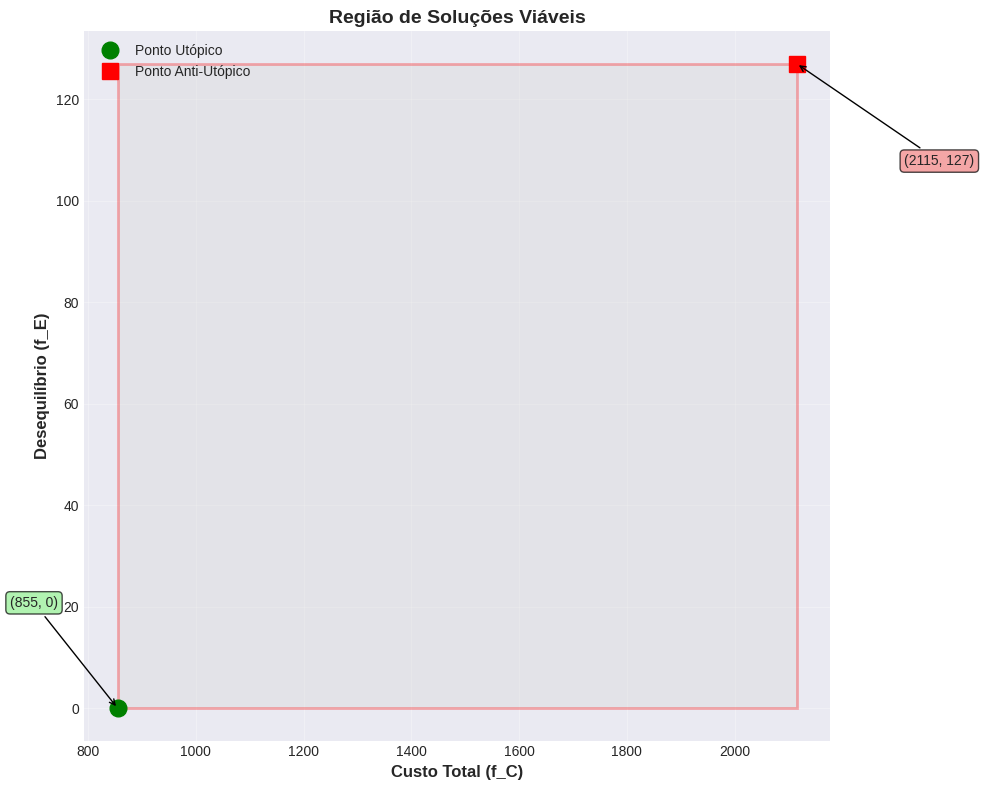

In [6]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(10, 8))

rect = Rectangle((f_C_utopico, f_E_utopico), 
                 f_C_antiutopico - f_C_utopico, 
                 f_E_antiutopico - f_E_utopico,
                 linewidth=2, edgecolor='red', facecolor='lightgray', alpha=0.3)
ax.add_patch(rect)

ax.plot(f_C_utopico, f_E_utopico, 'go', markersize=12, label='Ponto Utópico')
ax.plot(f_C_antiutopico, f_E_antiutopico, 'rs', markersize=12, label='Ponto Anti-Utópico')

ax.annotate(f'({f_C_utopico:.0f}, {f_E_utopico:.0f})',
            xy=(f_C_utopico, f_E_utopico), xytext=(f_C_utopico-200, f_E_utopico+20),
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
            arrowprops=dict(arrowstyle='->'))

ax.annotate(f'({f_C_antiutopico:.0f}, {f_E_antiutopico:.0f})',
            xy=(f_C_antiutopico, f_E_antiutopico), xytext=(f_C_antiutopico+200, f_E_antiutopico-20),
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
            arrowprops=dict(arrowstyle='->'))

ax.set_xlabel('Custo Total (f_C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Desequilíbrio (f_E)', fontsize=12, fontweight='bold')
ax.set_title('Região de Soluções Viáveis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Otimização MILP

In [7]:
import sys
sys.path.append('..')
from otimizacao_utils import criar_modelo_milp, resolver_milp, metodo_epsilon_restrito, calcular_delta, calcular_hipervolume_2d
from pyomo.opt import SolverFactory

solver = SolverFactory('glpk')
solver_name = 'glpk' if solver.available() else None
print(f"Solver: {solver_name}")

Solver: glpk


### 5.1 Resolver Extremos

In [8]:
modelo_custo = criar_modelo_milp(m, n, a, c, b, objetivo='custo')
sol_custo = resolver_milp(modelo_custo, a, c, solver_name=solver_name)

modelo_eq = criar_modelo_milp(m, n, a, c, b, objetivo='equilibrio')
sol_eq = resolver_milp(modelo_eq, a, c, solver_name=solver_name)

print(f"Min Custo: f_C={sol_custo['f_C']:.2f}, f_E={sol_custo['f_E']:.2f}")
print(f"Min Desequilíbrio: f_C={sol_eq['f_C']:.2f}, f_E={sol_eq['f_E']:.2f}")

Min Custo: f_C=888.00, f_E=17.00
Min Desequilíbrio: f_C=1329.00, f_E=0.00


### 5.2 Método ε-Restrito

In [ ]:
fronteira = metodo_epsilon_restrito(m, n, a, c, b, sol_eq['f_E'], sol_custo['f_E'], 
                                     num_pontos=30, solver_name=solver_name, verbose=False)

df_fronteira = pd.DataFrame([{'epsilon': s['epsilon'], 'f_C': s['f_C'], 'f_E': s['f_E']} for s in fronteira])
print(df_fronteira.to_string(index=False))

df_fronteira.to_csv(data_dir / 'resultados_fronteira_pareto.csv', index=False)

Gerando Fronteira de Pareto: 100%|██████████| 30/30 [25:10<00:00, 50.34s/ponto]  

  epsilon   f_C  f_E
 2.344828 923.0  2.0
 2.931034 923.0  2.0
 3.517241 909.0  3.0
 4.103448 909.0  3.0
 4.689655 909.0  3.0
 5.275862 909.0  3.0
 5.862069 909.0  3.0
 6.448276 906.0  6.0
 7.034483 903.0  7.0
 7.620690 903.0  7.0
 8.206897 902.0  8.0
 8.793103 902.0  8.0
 9.379310 902.0  8.0
 9.965517 902.0  8.0
10.551724 901.0 10.0
11.137931 901.0 10.0
11.724138 901.0 10.0
12.310345 899.0 12.0
12.896552 899.0 12.0
13.482759 899.0 12.0
14.068966 895.0 14.0
14.655172 895.0 14.0
15.241379 895.0 14.0
15.827586 895.0 14.0
16.413793 895.0 14.0
17.000000 888.0 17.0


In [35]:
df_fronteira = pd.read_csv(data_dir / 'resultados_fronteira_pareto.csv')

## 6. Visualização da Fronteira

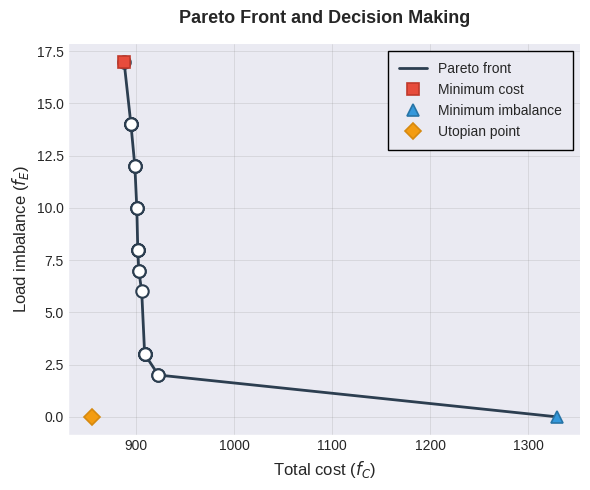

In [36]:
# 2. Plotagem da Fronteira
# NÃO recalcular - usar os pontos já resolvidos via MILP
# sol_custo e sol_eq já existem do código anterior


distancias = np.sqrt((df_fronteira['f_C'] - sol_eq['f_C'])**2 + (df_fronteira['f_E'] - sol_eq['f_E'])**2)
idx_mais_proximo = distancias.idxmin()

fig, ax = plt.subplots(figsize=(6, 5))

# Fronteira de Pareto com estilo profissional
ax.plot(df_fronteira['f_C'], df_fronteira['f_E'], '-', color='#2C3E50', 
        linewidth=2, label='Pareto front', zorder=3)
ax.plot([sol_eq['f_C'], df_fronteira.loc[idx_mais_proximo, 'f_C']], 
        [sol_eq['f_E'], df_fronteira.loc[idx_mais_proximo, 'f_E']], 
        '-', color='#2C3E50', linewidth=2, zorder=3)

# Pontos da fronteira
ax.scatter(df_fronteira['f_C'], df_fronteira['f_E'], c='white', s=80, 
           edgecolors='#2C3E50', alpha=1, linewidths=1.5, zorder=4)

# Soluções extremas (usar os pontos já calculados)
ax.plot(sol_custo['f_C'], sol_custo['f_E'], 's', color='#E74C3C', markersize=9, 
        label='Minimum cost', markeredgewidth=1.2, markeredgecolor='#C0392B', zorder=5)
ax.plot(sol_eq['f_C'], sol_eq['f_E'], '^', color='#3498DB', markersize=9, 
        label='Minimum imbalance', markeredgewidth=1.2, markeredgecolor='#2874A6', zorder=5)

# Ponto utópico
ax.plot(f_C_utopico, f_E_utopico, 'D', color='#F39C12', markersize=8, 
        label='Utopian point', markeredgewidth=1.2, markeredgecolor='#D68910', zorder=6)

# Configurações dos eixos
ax.set_xlabel('Total cost ($f_C$)', fontsize=12, fontweight='normal')
ax.set_ylabel('Load imbalance ($f_E$)', fontsize=12, fontweight='normal')
ax.set_title('Pareto Front and Decision Making', fontsize=13, fontweight='bold', pad=15)

# Legenda profissional
ax.legend(fontsize=10, loc='upper right', frameon=True, fancybox=False, 
          edgecolor='black', framealpha=1, borderpad=0.8)

# Grid sutil
ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax.set_axisbelow(True)

# Remover spines superiores e direitas para visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.savefig('fronteira_decisao_final.png', dpi=300, bbox_inches='tight', 
            transparent=True)
plt.show()

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path('.')
np.random.seed(42)

# 1. Gerar dados e TOPSIS
df_fronteira['Confiabilidade'] = np.random.uniform(7, 10, len(df_fronteira)) - (df_fronteira['f_E'] * 0.1)
df_fronteira['Robustez'] = np.random.uniform(2, 5, len(df_fronteira))

w = np.array([0.4, 0.2, 0.2, 0.2])
mat = df_fronteira[['f_C', 'f_E', 'Confiabilidade', 'Robustez']].values
norm = mat / np.linalg.norm(mat, axis=0)
pond = norm * w

ideal = np.array([pond[:,0].min(), pond[:,1].min(), pond[:,2].max(), pond[:,3].max()])
anti = np.array([pond[:,0].max(), pond[:,1].max(), pond[:,2].min(), pond[:,3].min()])

d_ideal = np.sqrt(((pond - ideal)**2).sum(axis=1))
d_anti = np.sqrt(((pond - anti)**2).sum(axis=1))
escolha = df_fronteira.iloc[(d_anti / (d_ideal + d_anti)).argmax()]

print(f"Solução Escolhida:\n{escolha}")


Solução Escolhida:
epsilon             3.517241
f_C               909.000000
f_E                 3.000000
Confiabilidade      8.895982
Robustez            3.777244
Name: 2, dtype: float64


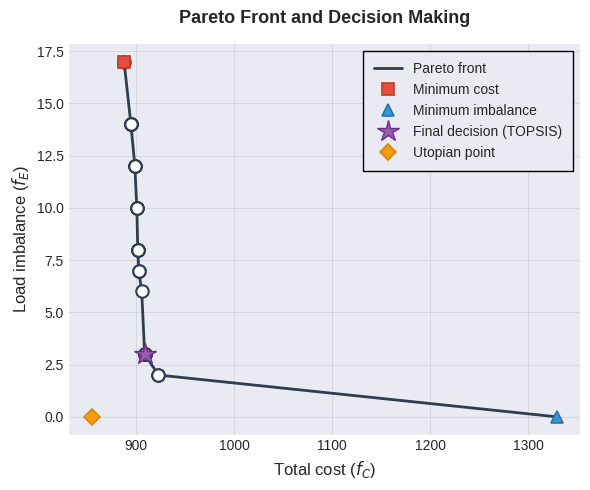

In [38]:
# 2. Plotagem da Fronteira

distancias = np.sqrt((df_fronteira['f_C'] - sol_eq['f_C'])**2 + (df_fronteira['f_E'] - sol_eq['f_E'])**2)
idx_mais_proximo = distancias.idxmin()

fig, ax = plt.subplots(figsize=(6, 5))

# Fronteira de Pareto com estilo profissional
ax.plot(df_fronteira['f_C'], df_fronteira['f_E'], '-', color='#2C3E50', 
        linewidth=2, label='Pareto front', zorder=3)
ax.plot([sol_eq['f_C'], df_fronteira.loc[idx_mais_proximo, 'f_C']], 
        [sol_eq['f_E'], df_fronteira.loc[idx_mais_proximo, 'f_E']], 
        '-', color='#2C3E50', linewidth=2, zorder=3)

# Pontos da fronteira
ax.scatter(df_fronteira['f_C'], df_fronteira['f_E'], c='white', s=80, 
           edgecolors='#2C3E50', alpha=1, linewidths=1.5, zorder=4)

# Soluções extremas
ax.plot(sol_custo['f_C'], sol_custo['f_E'], 's', color='#E74C3C', markersize=9, 
        label='Minimum cost', markeredgewidth=1.2, markeredgecolor='#C0392B', zorder=5)
ax.plot(sol_eq['f_C'], sol_eq['f_E'], '^', color='#3498DB', markersize=9, 
        label='Minimum imbalance', markeredgewidth=1.2, markeredgecolor='#2874A6', zorder=5)

# Decisão final
ax.plot(escolha['f_C'], escolha['f_E'], '*', color='#9B59B6', markersize=16, 
        label='Final decision (TOPSIS)', markeredgewidth=1, markeredgecolor='#6C3483', zorder=10)

# Ponto utópico
ax.plot(f_C_utopico, f_E_utopico, 'D', color='#F39C12', markersize=8, 
        label='Utopian point', markeredgewidth=1.2, markeredgecolor='#D68910', zorder=6)

# Configurações dos eixos
ax.set_xlabel('Total cost ($f_C$)', fontsize=12, fontweight='normal')
ax.set_ylabel('Load imbalance ($f_E$)', fontsize=12, fontweight='normal')
ax.set_title('Pareto Front and Decision Making', fontsize=13, fontweight='bold', pad=15)

# Legenda profissional
ax.legend(fontsize=10, loc='upper right', frameon=True, fancybox=False, 
          edgecolor='black', framealpha=1, borderpad=0.8)

# Grid sutil
ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax.set_axisbelow(True)

# Remover spines superiores e direitas para visual mais limpo
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.savefig('fronteira_decisao_final_topsis.png', dpi=300, bbox_inches='tight', 
            transparent=True)
plt.show()

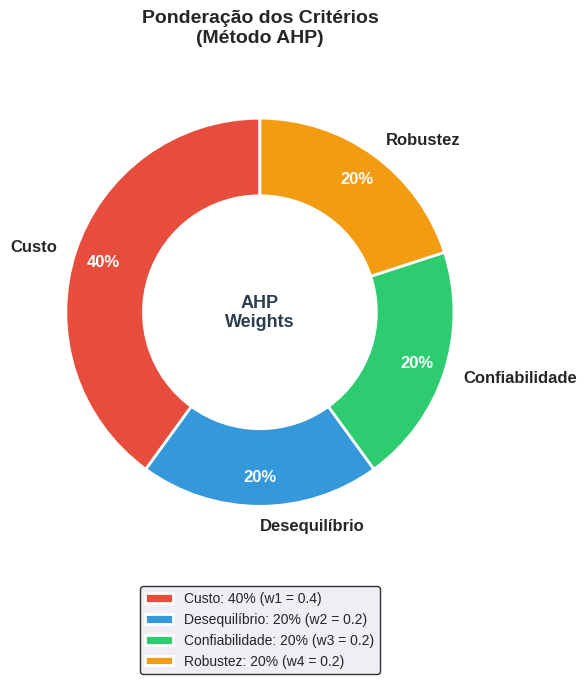

In [39]:
# Gráfico de Rosca (Donut Chart) - Ponderação AHP
fig, ax = plt.subplots(figsize=(6, 8))

# Dados
criterios = ['Custo', 'Desequilíbrio', 'Confiabilidade', 'Robustez']
pesos = [40, 20, 20, 20]
cores = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']  # Vermelho para custo, azul/verde para técnicos

# Criar o gráfico de rosca
wedges, texts, autotexts = ax.pie(pesos, labels=criterios, autopct='%1.0f%%',
                                    colors=cores,
                                    startangle=90, pctdistance=0.85,
                                    wedgeprops=dict(width=0.4, edgecolor='white', linewidth=2))

# Estilizar os textos
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# Adicionar título
ax.set_title('Ponderação dos Critérios\n(Método AHP)', 
             fontsize=14, fontweight='bold', pad=20)

# Adicionar legenda com os valores - posicionada embaixo
legend_labels = [f'{crit}: {peso}% (w{i+1} = {peso/100:.1f})' 
                 for i, (crit, peso) in enumerate(zip(criterios, pesos))]
ax.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
          fontsize=10, frameon=True, edgecolor='black', ncol=1)

# Adicionar anotação no centro
ax.text(0, 0, 'AHP\nWeights', ha='center', va='center', 
        fontsize=13, fontweight='bold', color='#2C3E50')

plt.tight_layout()
plt.savefig(data_dir / 'ponderacao_ahp.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

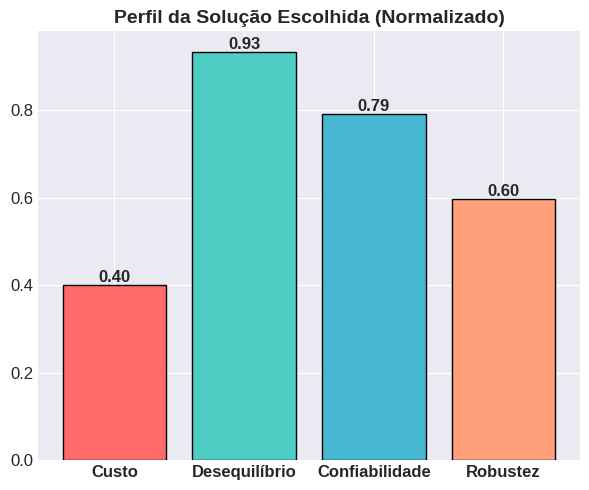

In [40]:
# 3. Plotagem do Perfil (Barras)
fig2, ax2 = plt.subplots(figsize=(6, 5))
cols = ['f_C', 'f_E', 'Confiabilidade', 'Robustez']
vals = []
for i, c in enumerate(cols):
    rng = df_fronteira[c].max() - df_fronteira[c].min()
    norm = (escolha[c] - df_fronteira[c].min()) / rng
    vals.append(1 - norm if i < 2 else norm)

bars = ax2.bar(['Custo', 'Desequilíbrio', 'Confiabilidade', 'Robustez'], vals, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], edgecolor='black')
ax2.bar_label(bars, fmt='%.2f', fontsize=12, fontweight='bold')
ax2.set_title('Perfil da Solução Escolhida (Normalizado)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='both', labelsize=12)
for label in ax2.get_xticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig(data_dir / 'perfil_solucao.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## 7. Indicadores de Qualidade

In [43]:
ponto_utopico = (f_C_utopico, f_E_utopico)
# Convert DataFrame to list of dicts for calcular_delta
fronteira_list = df_fronteira[['f_C', 'f_E']].to_dict('records')
delta = calcular_delta(fronteira_list, ponto_utopico)

ponto_ref = (f_C_antiutopico * 1.1, f_E_antiutopico * 1.1)

hv = calcular_hipervolume_2d(fronteira_list, ponto_ref)

hv_max = (ponto_ref[0] - f_C_utopico) * (ponto_ref[1] - f_E_utopico)
hv_ratio = (hv / hv_max) * 100

print(f"Delta (Δ): {delta:.4f}")
print(f"Hipervolume: {hv:.2f}")
print(f"Coverage: {hv_ratio:.1f}%")

Delta (Δ): 1.1642
Hipervolume: 21411.50
Coverage: 10.8%
